<a href="https://colab.research.google.com/github/ghgh415263/Mal_dectection/blob/main/model_VGG16_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''<keras.engine.input_layer.InputLayer object at 0x7f08804506d0>
<keras.layers.convolutional.Conv2D object at 0x7f08701ae650>1
<keras.layers.convolutional.Conv2D object at 0x7f08701aef10>2
<keras.layers.pooling.MaxPooling2D object at 0x7f08701cde90>3
<keras.layers.convolutional.Conv2D object at 0x7f08701ad510>4
<keras.layers.convolutional.Conv2D object at 0x7f08701ccc50>5
<keras.layers.pooling.MaxPooling2D object at 0x7f0880383e50>6
<keras.layers.convolutional.Conv2D object at 0x7f08701ce7d0>7
<keras.layers.convolutional.Conv2D object at 0x7f08701596d0>8
<keras.layers.convolutional.Conv2D object at 0x7f087015e1d0>9
<keras.layers.pooling.MaxPooling2D object at 0x7f0870163cd0>10
<keras.layers.convolutional.Conv2D object at 0x7f0870159410>11
<keras.layers.convolutional.Conv2D object at 0x7f08701c5350>12
<keras.layers.convolutional.Conv2D object at 0x7f0870196210>13
<keras.layers.pooling.MaxPooling2D object at 0x7f087f259a10>14
<keras.layers.convolutional.Conv2D object at 0x7f08813693d0>15
<keras.layers.convolutional.Conv2D object at 0x7f087f2e0050>16
<keras.layers.convolutional.Conv2D object at 0x7f0870172fd0>17
<keras.layers.pooling.MaxPooling2D object at 0x7f08700caa50>18'''

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/data/malimg_dataset.zip" -d "/content/dataset"

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.vgg16 import VGG16

import pathlib

class CustomCallback(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
        current_decayed_lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
        print("current decayed lr: {:0.7f}".format(current_decayed_lr))

DATA_PATH = "/content/dataset"
batch_size = 128
img_height = 224
img_width = 224
val_split = 0.2
interpolation = 'bicubic' #bicubic bilinear
seed = 4885

data_dir = pathlib.Path(DATA_PATH)

checkpoint_path = "/content/drive/MyDrive/Colab_Notebooks/save/4885/vgg16(25)-batch32-0.001/cp-{epoch:04d}.ckpt"
result_path = "/content/drive/MyDrive/Colab_Notebooks/save/4885/vgg16(25)-batch32-0.001/result.txt"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=val_split,
  color_mode='rgb',
  interpolation=interpolation,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=val_split,
  color_mode='rgb',
  interpolation=interpolation,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)


base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_height,img_width,3))
for layer in base_model.layers[:17]:
  layer.trainable=False

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    base_model,
    layers.Flatten(),
    keras.layers.Dropout(0.7),
    layers.Dense(25, activation='softmax')
])
    #layers.Dense(4096, activation='relu'),
    #layers.Dense(4096, activation='relu'),
    #keras.layers.Dropout(0.1),
    #layers.MaxPooling2D(pool_size=(2, 2), padding="valid"),
    #layers.Flatten(),
    #layers.Dense(25, activation='softmax')

model.summary()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2340,
    decay_rate=0.5,
    staircase=False) #staircase=False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#checkpoint_dir = os.path.dirname(checkpoint_path)
#model.load_weights("/content/drive/MyDrive/Colab_Notebooks/save/vgg16-1layer(drop 0.15)-bicubic,decay(0.6),maxp/cp-0098.ckpt")

'''def scheduler(epoch, lr):
  if epoch > 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)'''

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=500)

history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[cp_callback])

Found 9339 files belonging to 25 classes.
Using 7472 files for training.
Found 9339 files belonging to 25 classes.
Using 1867 files for validation.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 25)                627225    
                                                                 
Total params: 15,341,913
Trainable par

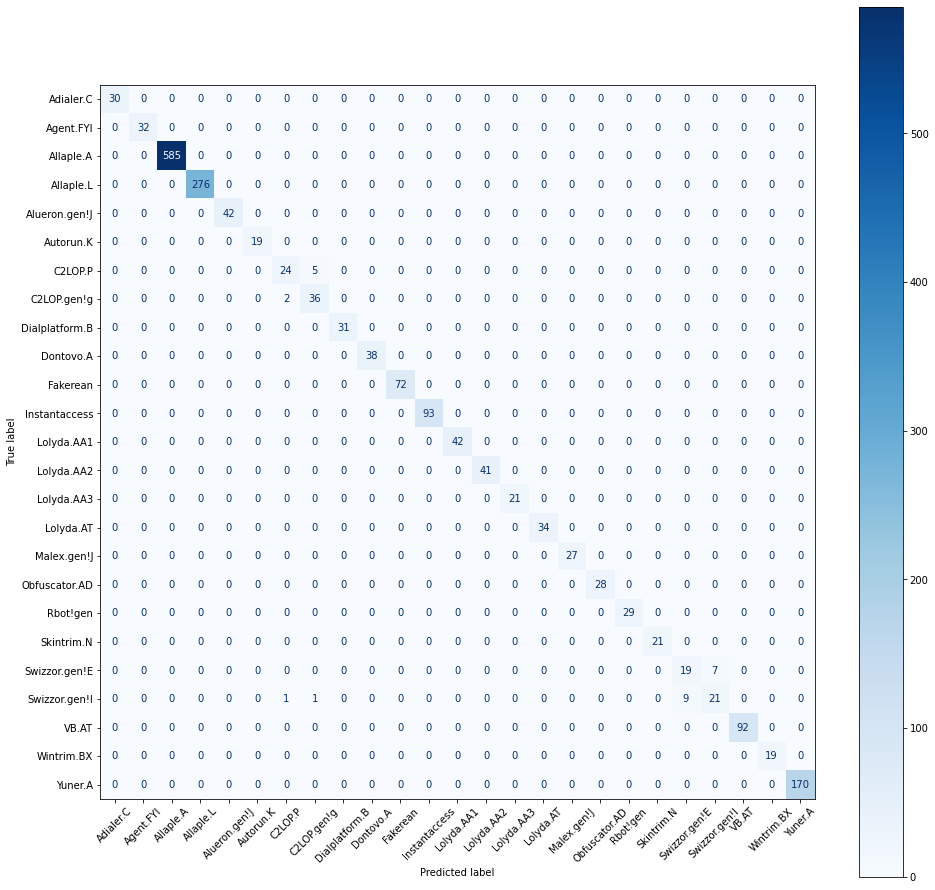

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_test = np.array([])
y_pred = np.array([])

for x,y in val_ds:
  y_test = np.append(y_test, y.numpy(), axis=0)
  tmp = (model.predict(x)).argmax(axis=-1)
  y_pred = np.append(y_pred, tmp, axis=0)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.class_names)
fig, ax = plt.subplots(figsize=(16,16))

disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.show()

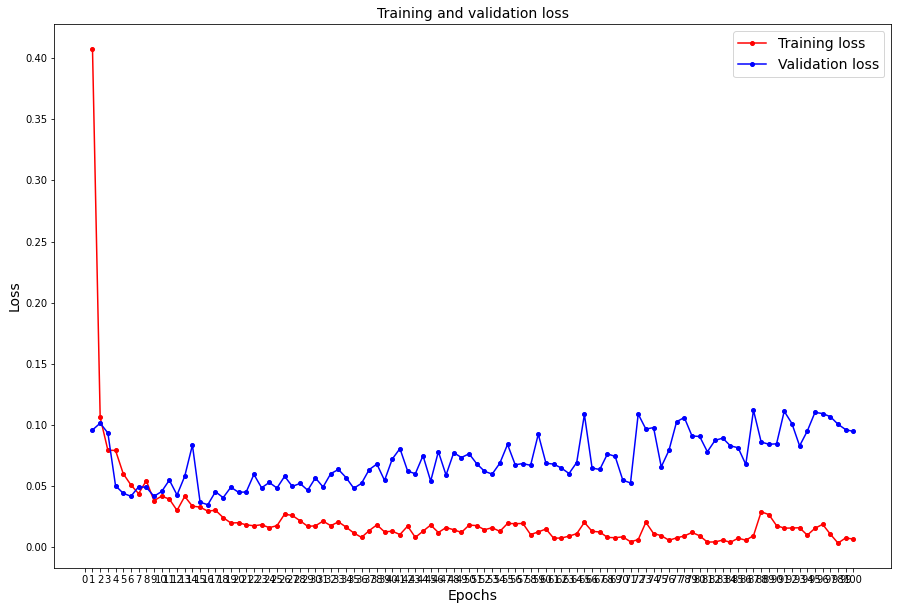

In [10]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'ro-', label='Training loss', markersize = 4)
plt.plot(epochs, val_loss, 'bo-', label='Validation loss', markersize = 4)
plt.title('Training and validation loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(range(len(acc) + 1), range(len(acc) + 1))

plt.show()

<Figure size 432x288 with 0 Axes>

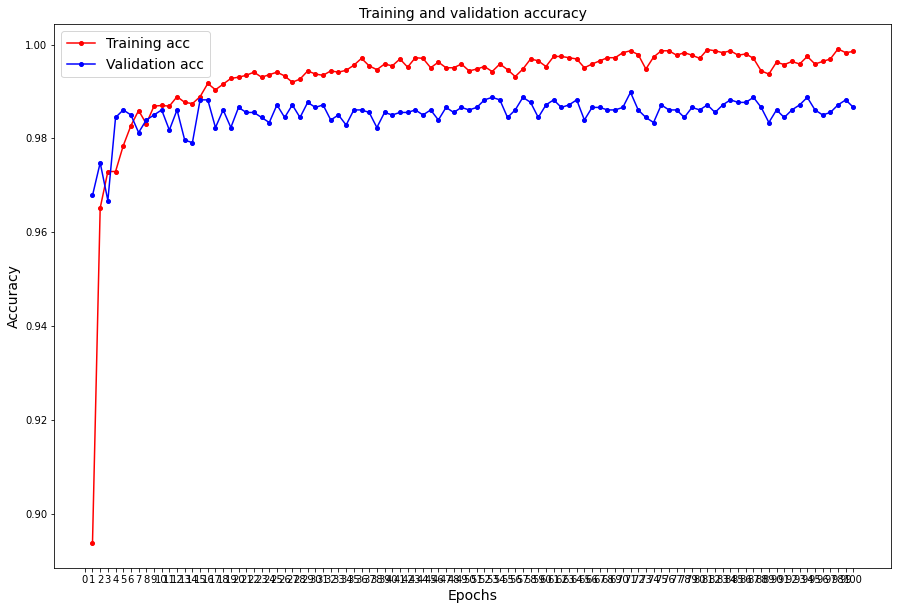

In [11]:
plt.clf()   # 그림을 초기화합니다

plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'ro-', label='Training acc', markersize = 4)
plt.plot(epochs, val_acc, 'bo-', label='Validation acc', markersize = 4)
plt.title('Training and validation accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(range(len(acc) + 1), range(len(acc) + 1))

plt.show()

In [7]:
print("%-8s" % "epoch", "%-23s" % "train_loss", "%-23s" % "val_loss", "%-23s" % "train_acc", "%-23s" % "val_acc")
print("=" * 99)
for i in range(1,len(acc)+1):
        print("%-8s" %i, "%-23s" % loss[i-1], "%-23s" % val_loss[i-1], "%-23s" % acc[i-1], "%-23s" % val_acc[i-1])

epoch    train_loss              val_loss                train_acc               val_acc                
1        0.4110178053379059      0.08962050825357437     0.8961455821990967      0.9657204151153564     
2        0.08549218624830246     0.08273088932037354     0.9702890515327454      0.9657204151153564     
3        0.06343317776918411     0.11735857278108597     0.9753747582435608      0.9651848077774048     
4        0.05020396038889885     0.06207689642906189     0.9820663928985596      0.9796465039253235     
5        0.04218988120555878     0.03920360654592514     0.9862151741981506      0.9817889928817749     
6        0.037758395075798035    0.04091443121433258     0.988088846206665       0.9839314222335815     
7        0.03287215158343315     0.0413726307451725      0.9883565306663513      0.9850026965141296     
8        0.0277165025472641      0.047030553221702576    0.9907655119895935      0.9817889928817749     
9        0.02902538701891899     0.0432557612657547    

In [ ]:
import sys

f = open(result_path, 'w')
sys.stdout = f
print("%-8s" % "epoch", "%-23s" % "train_loss", "%-23s" % "val_loss", "%-23s" % "train_acc", "%-23s" % "val_acc")
print("=" * 99)
for i in range(1,len(acc)+1):
        print("%-8s" %i, "%-23s" % loss[i-1], "%-23s" % val_loss[i-1], "%-23s" % acc[i-1], "%-23s" % val_acc[i-1])
sys.stdout = sys.__stdout__
f.close()